In [197]:
%matplotlib inline

from __future__ import print_function

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,floatX=float32,device=gpu,lib.cnmem=.95,scan.allow_gc=False"
import theano

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, minmax_scale, maxabs_scale
from sklearn.metrics import mean_squared_error
from sklearn.cluster import MiniBatchKMeans
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.optimizers import Nadam

import seaborn as sns
sns.set_style("whitegrid") 

import pep2space

MAX_POS=13

## 1. Coordinates and models
**window** - sliding window, predict the coordinate in the centre of the window.

**directional / bidirectional** - recurrent neural networks.

**straight** - predict each coordinate.

**difference** - predict differences between neighbour coordinates

**window + straight** - predict each coordinate.

### 1.1. Naive approach

Surround sequences by null symbols.

### 1.2. "Omega loops"

First and last amino acids depends on each other other. It is better than the naive approach:
<img src="loss/loss_x_dense_4_4_comparison_clust_and_onehot_1200it.png" width="80%">

### 1.3 Positional / length-positional

Add position or position/length for each amino acid to each dense layer. It helps:

<img src="loss/comparison/loss_x_dense_comparison_1500it.png" width="80%">

Interstinegly enough, if we train the model on CDRs and predict putative ones than the pos-len modification helps a lot:

<img src="loss/loss_dense_changeCDRs_1500it.png" width="80%">

### 1.4. Recurrent models

GRU models, 1500 iterations:
<img src="loss/comparison/loss_x_gru_comparison_1500it.png" width="80%">

### 1.5. Difference among coordinates (left-to-right / right-ot-left directions)

Due to the iterative nature the error is aggreageted through the sequence.

<img src="pred/pred_x_diff_left_coords.png" width="80%">

<img src="pred/pred_x_diff_right_coords.png" width="80%">


## 2. Amino acid transformations
**one-hot** - code each amino acid as a 20-dimensional vector with 1 at the index of the corresponding amino acid.

**kidera** - worked worse than one-hot.

**embeddings** - ??? (infer embeddings on the overall dataю)

**two-hot** - one-hot vector + one-hot vector for target amino acid.


## 3. Feature preprocessing

### 3.1. Scale the data

Scale the data to [0,1]. Tested on models with [128,64] dense layers, 4-4 window size, 2000 iterations.
- per column - scale each column independently:
```
MSE:
no scale:
    cdr - 1.61775   ***
    can - 0.0993797
MinMax:
    cdr - 2.43089   *
    can - 0.0978544
MaxAbs:
    cdr - 1.95208   **
    can - 0.0967865
```
- overall - scale the overall matrix:
```
no scale:
    cdr - 1.61775   ***
    can - 0.0993797
MinMax:
    cdr - 2.27693   *
    can - 0.105339
MaxAbs:
    cdr - 1.96837   **
    can - 0.0973526
```

### 3.2. Pre-clustering

Assign weights accroding to the clusters' sizes. Cluster weight = `ln(cluster size) / ln(minimal cluster size)`. Clustering helps:

<img src="loss/loss_x_dense_onehot_noscale_clust5.png" width="90%">

However prediction with clustering is a little bit off due to the small weights on big clusters:

<img src="pred/pred_strange_with_clustering.png" width="110%">


### 3.3. Pre-clustering with fading weights on clusters

???
???


## 4. Learning

### 4.1. Straightforward learning

<img src="loss/loss_x_densepos_4_4_comparison_clust_and_onehot_1200it.png" width="80%">


### 4.2. Change learning rate

Factor 0.3, patience 3
<img src="loss/loss_x_densepos_4_4_comparison_clust_and_onehot_changelr_factor03_patience3_1200it.png" width="80%">

Factor 0.1, patience 3
<img src="loss/loss_x_densepos_4_4_comparison_clust_and_onehot_changelr_factor01_patience3_1200it.png" width="80%">

Factor 0.1, patience 6
<img src="loss/loss_x_densepos_4_4_comparison_clust_and_onehot_changelr_factor01_patience6_1200it.png" width="80%">


### 4.3. Add putative sequences to batches

??? (to add noise)


## 5. Post-analysis

### 5.1. Ensembling

???

# 1-dimensional models

## Find which windows and layer sizes are the best

In [3]:
import importlib
from pep2space import model as pepmodel
from pep2space import eval as pepeval
pep2space = importlib.reload(pep2space)
pepeval = importlib.reload(pep2space.eval)
pepmodel = importlib.reload(pep2space.model)

best_models = [(4,4), (6,6)]
best_layers = [[128, 64]]

best_hist = {}
best_models_list = {}
best_models_loss = pd.DataFrame()

for l,r in best_models:
    for layers in best_layers:
        _, best_models_loss = pepmodel.train_model(MAX_POS, 0, "x", layers, l, r, 1500, 
                                                   best_hist, best_models_list, best_models_loss, 
                                                   features = "omega", model_type="dense")
        _, best_models_loss = pepmodel.train_model(MAX_POS, 0, "x", layers, l, r, 1500, 
                                                   best_hist, best_models_list, best_models_loss, 
                                                   features = "omega", model_type="dense_pos")
        _, best_models_loss = pepmodel.train_model(MAX_POS, 0, "x", layers, l, r, 1500, 
                                                   best_hist, best_models_list, best_models_loss, 
                                                   features = "omega", model_type="dense_poslen")
        
        _, best_models_loss = pepmodel.train_model(MAX_POS, 5, "x", layers, l, r, 1500, 
                                                   best_hist, best_models_list, best_models_loss, 
                                                   features = "omega", model_type="dense")
        _, best_models_loss = pepmodel.train_model(MAX_POS, 5, "x", layers, l, r, 1500, 
                                                   best_hist, best_models_list, best_models_loss, 
                                                   features = "omega", model_type="dense_pos")
        _, best_models_loss = pepmodel.train_model(MAX_POS, 5, "x", layers, l, r, 1500, 
                                                   best_hist, best_models_list, best_models_loss, 
                                                   features = "omega", model_type="dense_poslen")
        
print(best_hist.keys())

IndentationError: expected an indented block (<ipython-input-3-0805dd482161>, line 37)

## Visualize loss

In [215]:
importlib.reload(pep2space.preprocess)

left_win, right_win = 6, 6

df_cdr = pd.read_csv("data/cdr_coord_x.csv.gz")
df_can = pd.read_csv("data/can_coord_x.csv.gz")
X_can, y_can = pep2space.preprocess.onehot_omega_delta(df_can, left_win, right_win, MAX_POS, for_rnn=True, add_pos=True)
X_cdr, y_cdr = pep2space.preprocess.onehot_omega_delta(df_cdr, left_win, right_win, MAX_POS, for_rnn=True, add_pos=True)

input_shape = (left_win+right_win+2, len(pep2space.preprocess.CHARS))

In [199]:
X_cdr = [X_cdr, X_cdr[..., ::-1, ...], np.array([float((x % MAX_POS) + 1) / MAX_POS for x in range(X_cdr.shape[0])])]
y_cdr = [y_cdr_diff_forw, y_cdr_diff_back, y_cdr]

X_can = [X_can, X_can[..., ::-1, ...], np.array([float((x % MAX_POS) + 1) / MAX_POS for x in range(X_can.shape[0])])]
y_can = [y_can_diff_forw, y_can_diff_back, y_can]

/root/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: an index can only have a single Ellipsis (`...`); replace all but one with slices (`:`).
  if __name__ == '__main__':
/root/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: an index can only have a single Ellipsis (`...`); replace all but one with slices (`:`).


In [236]:
importlib.reload(pep2space.model)

model_list = {}
hist_list = {}
n_epochs = 1500
reduce_lr = pep2space.model.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, cooldown=1, min_lr=0.0005)

In [ ]:
model_name = "gru.forw.64.64"

model = pep2space.model.rnn_model(input_shape, 1, [64,64])
hist_obj = model.fit(X_can, y_can[:,1], batch_size=32, 
          epochs=n_epochs, verbose=0, callbacks=[reduce_lr],
          validation_data = (X_cdr, y_cdr[:,1]))
model_list[model_name] = model
hist_list[model_name] = hist_obj

In [ ]:
importlib.reload(pep2space.model)

model_name = "gru.back.64.64"

model = pep2space.model.rnn_model(input_shape, 1, [64,64])
hist_obj = model.fit(X_can, y_can[:,2], batch_size=32, 
          epochs=n_epochs, verbose=0, callbacks=[reduce_lr],
          validation_data = (X_cdr, y_cdr[:,2]))
model_list[model_name] = model
hist_list[model_name] = hist_obj

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


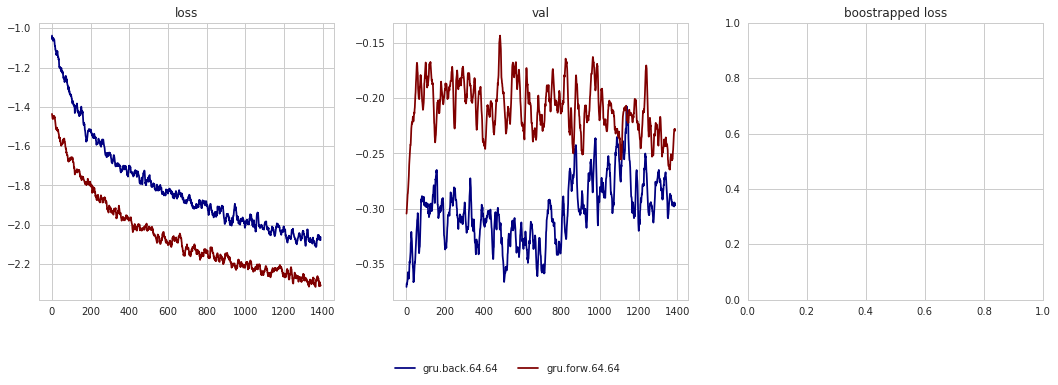

In [ ]:
STARTING_FROM = 100

fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(18)
fig.set_figheight(8)

plt.gcf().subplots_adjust(bottom=0.4)

def smooth(vec):
    res = []
    window = 5
    step = 1
    for i in range(window, len(vec)-window, step):
        res.append(np.mean(vec[i-window:i+window+1]))
    return res


cur_hist = hist_list
best_models = sorted([(h, np.mean(cur_hist[h].history["val_loss"][-5:])) for h in cur_hist], key=lambda x: x[1])[:10]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, len(best_models))]

for i, (h, _) in enumerate(sorted(best_models, key=lambda x:x[0])):
    ax[0].plot(np.log2(smooth(cur_hist[h].history["loss"][STARTING_FROM:])), label=h, c=colors[i])
    ax[1].plot(np.log2(smooth(cur_hist[h].history["val_loss"][STARTING_FROM:])), label=h, c=colors[i])
    
# best_models_loss.sort_values("model", inplace=True)
# ax[2] = sns.boxplot(y = "val_loss", x = "model", data = best_models_loss)
# ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
    
ax[0].set_title("loss")
ax[1].set_title("val")
ax[2].set_title("boostrapped loss")
ax[0].legend(bbox_to_anchor=(2, -.2), loc='upper right', ncol = 2)

# plt.savefig("loss/loss_dense_changeCDRs_1500it.png")

## Visualize predictions

In [249]:
model = model_list["gru.forw.64.64"]

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


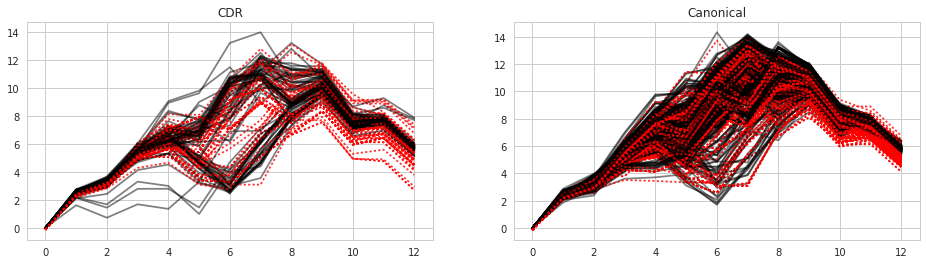

In [250]:
def plot_pred(df, pred, ax, title):
    trans = pred.reshape((len(df),MAX_POS))
    for i in range(len(df)):
        ax.plot(range(MAX_POS), df.iloc[i,3:16], c="black", alpha=.5, label="real")
        ax.plot(range(MAX_POS), trans[i,:], c = "red", linestyle="dotted", alpha=.8, label="pred")
    ax.set_title(title)


fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(16)
    
# Predicted and real coordinates
# df_cdr = pd.read_csv("data/cdr_coord_x.csv.gz")
# df_can = pd.read_csv("data/can_coord_x.csv.gz")
# X_cdr, y_cdr = pep2space.preprocess.onehot_omega(df_cdr, 4, 4, MAX_POS, False)
# X_can, y_can = pep2space.preprocess.onehot_omega(df_can, 4, 4, MAX_POS, False)

# X_cdr =  [X_cdr, 
#           np.array([float((x % max_pos) + 1) / MAX_POS for x in range(X_cdr.shape[0])]), 
#           np.full((X_cdr.shape[0],1), MAX_POS)]

# X_can =  [X_can, 
#           np.array([float((x % max_pos) + 1) / MAX_POS for x in range(X_can.shape[0])]), 
#           np.full((X_can.shape[0],1), MAX_POS)]

pred = model.predict(X_cdr)
pred = pep2space.preprocess.diff_to_abs(pred, MAX_POS)
plot_pred(df_cdr, pred, ax[0], "CDR")

pred = model.predict(X_can)
pred = pep2space.preprocess.diff_to_abs(pred, MAX_POS)
plot_pred(df_can, pred, ax[1], "Canonical")

plt.savefig("pred/pred_x_diff_left_coords.png")

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


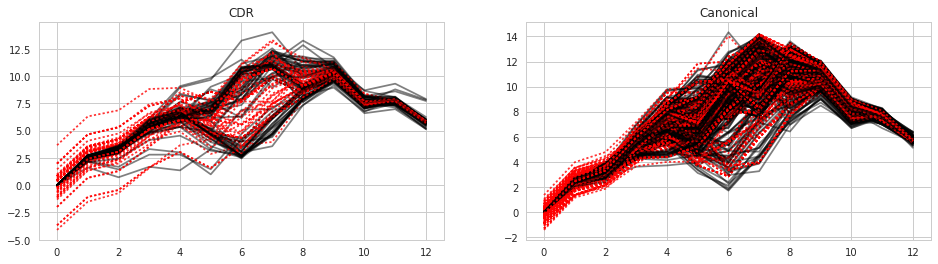

In [251]:
model = model_list["gru.back.64.64"]

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(16)

pred = model.predict(X_cdr)
pred = pep2space.preprocess.diff_to_abs(pred, MAX_POS, rev=True)
plot_pred(df_cdr, pred, ax[0], "CDR")

pred = model.predict(X_can)
pred = pep2space.preprocess.diff_to_abs(pred, MAX_POS, rev=True)
plot_pred(df_can, pred, ax[1], "Canonical")

plt.savefig("pred/pred_x_diff_right_coords.png")

# 2-dimensional models

In [ ]:
def to_vec_onehot(df, df_add, left_window, right_window):
    X = np.zeros((len(df)*MAX_POS, (left_window+right_window+1) * len(chars)), dtype=bool)
    y = np.zeros((len(df)*MAX_POS, 2), dtype=np.float32)
    for seq_i, seq in enumerate(df["sequence"]):
        seq = "X"*left_window + seq + "X"*right_window
        for index, target_pos in enumerate(range(left_window + 1, len(seq) - right_window)):
            target_aa = seq[target_pos]
            for amb_pos, amb_aa in enumerate(seq[target_pos-left_window : target_pos+right_window+1]):
                if amb_aa != "X":
                    X[seq_i*MAX_POS + index, amb_pos*len(chars):(amb_pos+1)*len(chars)] = one_hot[amb_aa]
            y[seq_i*MAX_POS + index, 0] = df[[4 + index]].iloc[seq_i]
            y[seq_i*MAX_POS + index, 1] = df_add[[4 + index]].iloc[seq_i]
    return X, y


def train_models(coord, layers, left_window, right_window, n_epochs, hist):
    model_name = "left" + str(left_window) + "_right" + str(right_window)
    if model_name not in hist:
        df_cdr = pd.read_csv("data/cdr_coord_" + coord[0] + ".csv.gz")
        df_can = pd.read_csv("data/can_coord_" + coord[0] + ".csv.gz")
        
        df_cdr_add = pd.read_csv("data/cdr_coord_" + coord[1] + ".csv.gz")
        df_can_add = pd.read_csv("data/can_coord_" + coord[1] + ".csv.gz")

        X_can, y_can = to_vec_onehot(df_can, df_can_add, left_window, right_window)
        X_cdr, y_cdr = to_vec_onehot(df_cdr, df_cdr_add, left_window, right_window)

        model = dense_model((20*(right_window+left_window+1),), 2, layers)

        hist[model_name] = model.fit(X_can, y_can, batch_size=128, epochs=n_epochs, verbose=0, validation_data=(X_cdr, y_cdr))


# hist = {}
# for left_window in range(8):
#     for right_window in range(8):
#         train_models("x", left_window, right_window, 2000, hist)

In [ ]:
best_models = [(3,3), (4,4), (5,5), (6,6)]

best_hist = {}
for l,r in best_models:
    train_models(["x", "y"], [128,64], l, r, 2000, best_hist)

In [ ]:
fig, ax = plt.subplots(nrows=1, sharex=True, ncols=2)
fig.set_figwidth(16)
fig.set_figheight(10)

def smooth(vec):
    res = []
    window = 10
    step = 1
    for i in range(window, len(vec)-window, step):
        res.append(np.mean(vec[i-window:i+window+1]))
    return res

cur_hist = best_hist
best_models = sorted([(h, np.mean(cur_hist[h].history["val_loss"][-5:])) for h in cur_hist], key=lambda x: x[1])[:8]

for i, (h, _) in enumerate(sorted(best_models)):
    ax[0].plot(np.log2(smooth(cur_hist[h].history["loss"][100:])), label=h)
    ax[1].plot(np.log2(smooth(cur_hist[h].history["val_loss"][100:])), label=h)


ax[0].set_title("loss")
ax[1].set_title("val")
ax[0].legend()
ax[1].legend()

plt.savefig("loss/loss_xy_dense2layer_onehot_2000it.png")

In [ ]:
def to_vec_onehot(df, df_add, left_window, right_window):
    X = np.zeros((len(df)*MAX_POS, (left_window+right_window+1) * len(chars)), dtype=bool)
    y = np.zeros((len(df)*MAX_POS, 2), dtype=np.float32)
    for seq_i, seq in enumerate(df["sequence"]):
        seq = "X"*left_window + seq + "X"*right_window
        for index, target_pos in enumerate(range(left_window + 1, len(seq) - right_window)):
            target_aa = seq[target_pos]
            for amb_pos, amb_aa in enumerate(seq[target_pos-left_window : target_pos+right_window+1]):
                if amb_aa != "X":
                    X[seq_i*MAX_POS + index, amb_pos*len(chars):(amb_pos+1)*len(chars)] = one_hot[amb_aa]
            y[seq_i*MAX_POS + index, 0] = df[[4 + index]].iloc[seq_i]
            y[seq_i*MAX_POS + index, 1] = df_add[[4 + index]].iloc[seq_i]
    return X, y


df_cdr = pd.read_csv("data/cdr_coord_x.csv.gz")
df_can = pd.read_csv("data/can_coord_x.csv.gz")

df_cdr_add = pd.read_csv("data/cdr_coord_y.csv.gz")
df_can_add = pd.read_csv("data/can_coord_y.csv.gz")

X_can, y_can = to_vec_onehot(df_can, df_can_add, 5, 5)
X_cdr, y_cdr = to_vec_onehot(df_cdr, df_cdr_add, 5, 5)

model = dense_model((20*(5+5+1),), 2, [128, 64])

model.fit(X_can, y_can, batch_size=128, epochs=2000, verbose=0, validation_data=(X_cdr, y_cdr))

In [ ]:
# Predicted and real coordinates
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(16)
fig.set_figheight(10)


pred = model.predict(X_cdr)
pred_x, pred_y = pred[:,0], pred[:,1]

df_cdr = pd.read_csv("data/cdr_coord_x.csv.gz")
trans = pred_x.reshape((len(df_cdr),12))
for i in range(len(df_cdr)):
    ax[0][0].plot(range(12), df_cdr.iloc[i,4:16], c="black", alpha=.5, label="real")
    ax[0][0].plot(trans[i,:], c = "red", linestyle="dotted", alpha=.7, label="pred")
ax[0][0].set_title("CDR X")

df_cdr = pd.read_csv("data/cdr_coord_y.csv.gz")
trans = pred_y.reshape((len(df_cdr),12))
for i in range(len(df_cdr)):
    ax[1][0].plot(range(12), df_cdr.iloc[i,4:16], c="black", alpha=.5, label="real")
    ax[1][0].plot(trans[i,:], c = "red", linestyle="dotted", alpha=.7, label="pred")
ax[1][0].set_title("CDR Y")

    
pred = model.predict(X_can)
pred_x, pred_y = pred[:,0], pred[:,1]

df_can = pd.read_csv("data/can_coord_x.csv.gz")
trans = pred_x.reshape((len(df_can),12))
for i in range(len(df_can)):
    ax[0][1].plot(range(12), df_can.iloc[i,4:16], c="black", alpha=.5, label="real")
    ax[0][1].plot(trans[i,:], c = "red", linestyle="dotted", alpha=.7, label="pred")
ax[0][1].set_title("Canonical X")

df_can = pd.read_csv("data/can_coord_y.csv.gz")
trans = pred_y.reshape((len(df_can),12))
for i in range(len(df_can)):
    ax[1][1].plot(range(12), df_can.iloc[i,4:16], c="black", alpha=.5, label="real")
    ax[1][1].plot(trans[i,:], c = "red", linestyle="dotted", alpha=.7, label="pred")
ax[1][1].set_title("Canonical Y")

plt.savefig("pred/pred_xy_dense2layer_onehot_2000it.png")

In [ ]:
pred = model.predict(X_cdr)
pred_x, pred_y = pred[:,0], pred[:,1]
pred_x[11]